In [1]:
#import findspark
#findspark.init()
import pyspark

import pandas as pd
import os
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
from pyspark.sql import SparkSession

In [2]:
spark= SparkSession.builder.appName("TPCH Data Z=0.5").getOrCreate()
#spark = SparkSession.builder.master("spark://sp-manager:7077").appName("Practice1").getOrCreate()

23/04/04 14:14:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
spark

In [4]:
def load_table(filename):
    tpch_df = spark.read.format('csv') \
    .option('header', 'false') \
    .option('delimiter', '|') \
    .load(filename, inferSchema='true')    
    return tpch_df

def getFieldList(tablename):
    dss_ddl_file = tpch_home + "/dss.ddl"
    table=tablename
    with open(dss_ddl_file, 'r') as file:
        data = file.read()
    str_pos= data.index(table)
    end_pos= data.index(";",str_pos)
    data=data[str_pos+len(table)+3: end_pos]    
    data =[i.strip()for i in data.split("\n")]
    fields=[]
    for line in data:
        fields.append(line.split()[0])
    return fields   

In [5]:
#tpch_home = "/usr/share/ApacheSpark/data/tpch/TPC-H-V3.0.1/dbgen"
tpch_home = "/usr/share/ApacheSpark/data/tpch/TPC-H-Skew"
z_path="/z_2"

path= tpch_home + z_path

# Get a list of all .tbl files in the directory
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.tbl')]

# Print the list of files
print(files)

['supplier.tbl', 'order.tbl', 'partsupp.tbl', 'nation.tbl', 'lineitem.tbl', 'region.tbl', 'part.tbl', 'customer.tbl']


In [6]:
tablename= "lineitem.tbl";
filename= path + "/"+tablename
tpch_df = load_table(filename)
print(f"Total Rows in {tablename}:", tpch_df.count())

Total Rows in lineitem.tbl: 600000


In [7]:
tpch_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: integer (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: timestamp (nullable = true)
 |-- _c11: timestamp (nullable = true)
 |-- _c12: timestamp (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)



In [8]:
tpch_df.createOrReplaceTempView("lineitem_tbl")

In [9]:
tpch_df1=spark.sql("select _c4,_c5,_c6, _c10, _c11, _c12 from lineitem_tbl")

In [10]:
tpch_df1.show(2)

+---+--------+----+-------------------+-------------------+-------------------+
|_c4|     _c5| _c6|               _c10|               _c11|               _c12|
+---+--------+----+-------------------+-------------------+-------------------+
| 17|24386.67|0.04|1996-03-13 00:00:00|1996-02-12 00:00:00|1996-03-22 00:00:00|
| 17|24386.67|0.04|1996-03-13 00:00:00|1996-02-12 00:00:00|1996-03-22 00:00:00|
+---+--------+----+-------------------+-------------------+-------------------+
only showing top 2 rows



How to get data from spark dataframe to python

In [11]:
%%time
psdf = tpch_df1.pandas_api()

CPU times: user 107 ms, sys: 26.1 ms, total: 134 ms
Wall time: 210 ms


In [12]:
psdf.describe()

23/04/04 14:15:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


/usr/local/spark/python/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


,_c4,_c5,_c6,_c10,_c11,_c12
count,600000.000000,600000.000000,600000.000000,600000,600000,600000
mean,21.000000,30947.907436,0.055564,1996-01-14 22:07:41.136000,1995-12-21 11:08:28.476000,1996-01-24 01:28:18.306000
min,1.000000,976.060000,0.000000,1992-01-23 00:00:00,1992-02-13 00:00:00,1992-01-30 00:00:00
25%,17.000000,24386.670000,0.040000,1996-03-13 00:00:00,1996-02-12 00:00:00,1996-03-22 00:00:00
50%,17.000000,24386.670000,0.040000,1996-03-13 00:00:00,1996-02-12 00:00:00,1996-03-22 00:00:00
75%,28.000000,31329.600000,0.090000,1996-03-13 00:00:00,1996-02-12 00:00:00,1996-03-22 00:00:00
max,50.000000,93397.500000,0.100000,1998-11-24 00:00:00,1998-10-24 00:00:00,1998-12-24 00:00:00
std,8.939829,14909.955992,0.026210,None,None,None


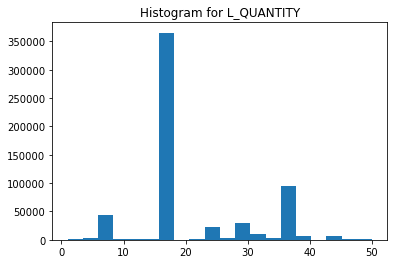

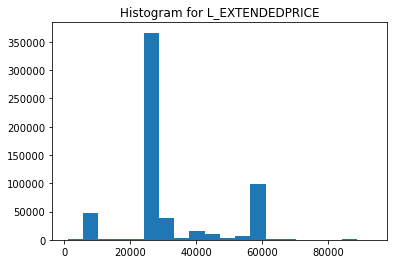

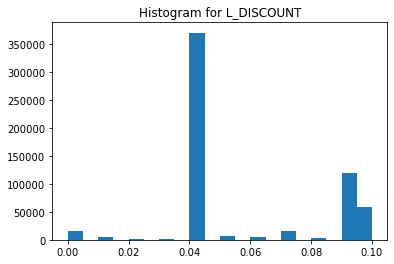

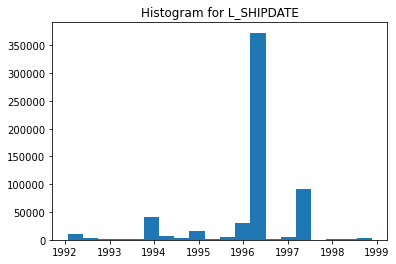

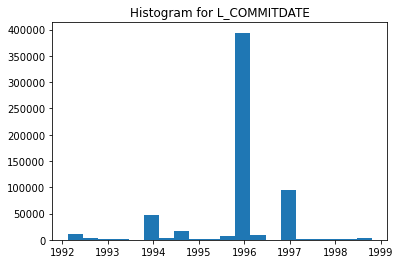

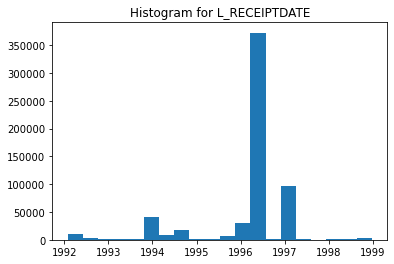

In [13]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

# Create a random number generator with a fixed seed for reproducibility
field_List= getFieldList(tablename="LINEITEM")
col_list= tpch_df.columns
n_bins = 20

for col in psdf.columns: 
    dist1 = psdf[col]    
    field_label = field_List[col_list.index(col)]
    fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=False)
    axs.hist(dist1, bins=n_bins)
    axs.set_title(f"Histogram for {field_label}")

In [14]:
spark.stop()